In [1]:
import json
import sys
import os
import re
import string
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt

In [2]:
def file_getter(name):
    return os.path.join(os.getcwd(), 'data', name + '.json')
data = {}
files = ['train', 'test', 'dev']
for json_data in files:
    with open(file_getter(json_data)) as infile:
        data[json_data] = json.load(infile)

In [3]:
def flat_map(xs):
    ys = []
    for x in xs:
        ys.extend(x)
    return ys

In [4]:
#'Polarity': sentiment label ('Negative', 'Positive')
#'Intensity': sentiment intensity ('Standard', 'Strong', 'Slight')
polarities = {
    'Negative': -1,
    'Positive': 1
}
intensities = {
    'Standard': 1,
    'Slight': 2,
    'Strong': 3
}

def make_valence(v):
    if v == 0:
        return 1
    elif v > 1:
        return 2
    else:
        return 0
    
def make_valence(v):
    return v

In [5]:

pattern = re.compile('[\W_]+')
clean = lambda text : pattern.sub(' ', text)

In [6]:
min_sent = -3
max_sent = 3

def norm_sent(sent_arr):
    if len(sent_arr) == 0:
        # average 0 1 _2_ 3 4
        return 2
    avg = sum(sent_arr)/len(sent_arr)
    normed = (avg-min_sent) / (max_sent - min_sent)
    # beef the sentiments up to 4 for more sparsity (0-4) => mimicking 1-5 stars
    return round(normed * 4)

In [7]:
def get_sentiments():
    texts = []
    sentiments = []
    for file in files:
        tmp = data[file]
        for item in tmp:
            text_valence = []
            opinions = item['opinions']
            if len(opinions) > 0:
                # handle sentiment
                targets = []
                for opinion in opinions:
                    target, target_span = opinion['Target']
                    polarity = opinion['Polarity']
                    intensity = opinion['Intensity']

                    if len(target) > 0 and polarity is not None and intensity is not None:
                        #targets.append([target[0], target_span[0], valence])
                        text_valence.append(polarities[polarity] * intensities[intensity])
                #unique_targets = [list(x) for x in set(tuple(x) for x in targets)]            
                cleaned = clean(item['text']).strip()
                MIN_SENT_LEN = 50
                if len(cleaned) > MIN_SENT_LEN:
                    texts.append(cleaned)
                    sentiments.append(norm_sent(text_valence))

                    
    return [texts, sentiments]


In [8]:
texts, sentiments = get_sentiments()
df = pd.DataFrame(list(zip(texts, sentiments)), columns = ['text', 'sentiment'])
df

,text,sentiment
0,Baksiden er sort blank og skinnende med et dek...,3
1,Skjermen er helt klart visuelt utfordrende noe...,3
2,Uansett hva man måtte mene om utseendet så er ...,3
3,En mer allsidig og tilkoblingsvennlig skjerm h...,2
4,Skjermen kan bare vippes ikke heves senkes ell...,1
...,...,...
4735,På sitt sterkeste og beste er stykket nettopp ...,3
4736,Dette igjen stiller store krav til diksjon og ...,2
4737,Især Thomas Bipin Olsen sliter til tider men e...,2
4738,Også Iselin Shumba med sin sceniske sikkerhet ...,3


<AxesSubplot:>

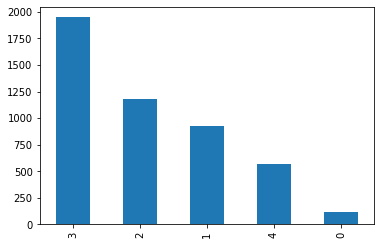

In [9]:
df.sentiment.value_counts().plot(kind='bar')

In [10]:
%df.to_csv('sentiment_data.csv')

In [12]:
df.describe()

,sentiment
count,4740.000000
mean,2.403797
std,1.010927
min,0.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,4.000000


In [13]:
df.sentiment.unique()

array([3, 2, 1, 4, 0], dtype=int64)

In [14]:
model_name = "ltgoslo/norbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [28]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 64
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
# EPOCHS = 1
LEARNING_RATE = 1e-05

In [53]:
class SentimentData(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.sentiment
        #self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            #max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [54]:
train, test = train_test_split(df, test_size=0.2)

In [55]:
print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train.shape))
print("TEST Dataset: {}".format(test.shape))

training_set = SentimentData(train, tokenizer, MAX_LEN)
testing_set = SentimentData(test, tokenizer, MAX_LEN)

FULL Dataset: (4740, 2)
TRAIN Dataset: (3792, 2)
TEST Dataset: (948, 2)


In [68]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 1,
                'pin_memory': True
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 1,
                'pin_memory': True
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [69]:
class Norec(torch.nn.Module):
    def __init__(self, model):
        super(Norec, self).__init__()
        self.l1 = model
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [70]:
model = Norec(AutoModel.from_pretrained(model_name, num_labels=5))

In [71]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce GTX 1080


In [72]:
model.to(device)
print(1)

1


In [73]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)

In [74]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [ ]:
next(iter(training_loader))

In [75]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return

In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
    train(epoch)

# BERT (NorBert)

In [29]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, pipeline, Trainer, TrainingArguments, AdamW
import torch
from torch.utils.data import DataLoader



There are 1 GPU(s) available.
Device name: NVIDIA GeForce GTX 1080


In [73]:
class NorecFineDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = NorecFineDataset(train_encodings, train_labels)
val_dataset = NorecFineDataset(val_encodings, val_labels)

NameError: name 'train_labels' is not defined

In [32]:
for name, param in model.named_parameters():
    param.requires_grad = False

In [69]:


class NorecFine(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
# X_train, X_val, y_train, y_val

train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)

train_data = NorecFine(train_encodings, y_train)
val_data = NorecFine(val_encodings, y_val)

data loaded


1523

In [80]:
tokenizer("dette er rævva")

{'input_ids': [102, 11864, 3638, 1238, 20489, 3605, 103], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [82]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)

In [84]:
num_labels = 3
model = AutoModel.from_pretrained(model_name, num_labels=num_labels)

In [85]:
batch_size = 10

args = TrainingArguments(
    "test sent",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [86]:
args

TrainingArguments(output_dir=test sent, overwrite_output_dir=False, do_train=False, do_eval=None, do_predict=False, evaluation_strategy=IntervalStrategy.EPOCH, prediction_loss_only=False, per_device_train_batch_size=10, per_device_eval_batch_size=10, gradient_accumulation_steps=1, eval_accumulation_steps=None, learning_rate=2e-05, weight_decay=0.01, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs\May25_18-24-31_desktop, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, save_total_limit=None, no_cuda=False, seed=42, fp16=False, fp16_opt_level=O1, fp16_backend=auto, fp16_full_eval=False, local_rank=-1, tpu_num_cores=None, tpu_metrics_debug=False, debug=False, dataloader_drop_last=False, eval_steps=500, dataloader_num_workers=0, past_index=-1, run_name=

In [87]:

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [89]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_encodings,
    eval_dataset=val_encodings,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [90]:
trainer.train()

AttributeError: 'list' object has no attribute 'keys'